In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import pymorphy2
import pymystem3
import re
import numpy as np

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score, StratifiedKFold, validation_curve, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

In [3]:
import matplotlib.pyplot as plt


%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
def set_answer(predictions, file_name):
    dataframe = pd.DataFrame(predictions, columns=['target'], index=np.arange(200000, 370179))
    dataframe.to_csv('data/'+str(file_name)+'.csv', index_label='id')

In [6]:
def get_data(processed=False):
    if processed:
        train_data = pd.read_csv('data/train_processed3.txt', sep='\t', index_col='id',  encoding='utf-8')
        test_data = pd.read_csv('data/test_processed3.txt', sep='\t', index_col='id', encoding='utf-8') 
    else:
        train_data = pd.read_csv('data/train.csv', sep='\t', index_col='id')
        test_data = pd.read_csv('data/test.csv', sep='\t', index_col='id') 
    return (train_data, test_data)

In [7]:
## Токенизатор

def get_lemmas(text):    
    #text = BeautifulSoup(text, 'lxml').get_text()       
    #lemms = [morph.parse(w)[0].normal_form for w in text.split()]    
    lemms = [w for w in text.split()]    
    return " ".join([x for x in lemms if (re.match('^[a-zа-яё]+(-[a-zа-яё]+)*$', x) and len(x)>2)])
       
def getVacanciesLemmas(texts):  
    texts = np.array(texts)    
    processed = np.vectorize(get_lemmas, otypes=[str])              
    return processed(texts)

In [8]:
## Функция для красивого вывода наиболее оптимальных параметров обучения
def print_test_results(SearchCV, num=10, top=True):    
    if top :return pd.DataFrame(SearchCV.cv_results_).sort_values(by='mean_test_score', ascending=False).head(num).T
    return pd.DataFrame(SearchCV.cv_results_).sort_values(by='mean_test_score', ascending=False).tail(num).T

In [10]:
import nltk
from nltk.corpus import stopwords

def get_vocabulary(corpus):
    vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words=stopwords.words('russian'))
    vectorizer.fit(corpus)
    return vectorizer.vocabulary_

In [11]:
class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    Please note that this is the opposite convention to scikit-learn feature
    matrixes (where the first index corresponds to sample).

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


In [193]:
train_data, test_data = get_data(True)

In [12]:
pd.set_option('max_colwidth',  2000)
train_data[11601:11602]

,name,description,target,nameprocessed,descriptionprocessed
id,,,,,
11601,Региональный менеджер (Спутниковое ТВ),"<p><strong>Обязанности:</strong></p> <ul> <li>Развитие территории, эффективное построение дилерской сети;</li> <li>Выполнение плана продаж на закрепленной территории;</li> <li>Поиск и привлечение партнеров на закрепленной территории;</li> <li>Работа с сформированной партнерской базой;</li> <li>Ведение переговоров, поддержка и сопровождение партнеров;</li> <li>Проведение обучения стандартам продаж для партнеров;</li> <li>Обеспечение проведения запланированных маркетинговых акций и других мероприятий, направленных на увеличение продаж и продвижение продукции/услуг;</li> <li>Ведение документооборота, отчетности.</li> <li>Сопровождение отгрузок и контроль дебиторской задолженности.</li> </ul> <p><strong>Требования:</strong></p> <ul> <li>Успешный опыт продаж, работы с клиентами на рынке B2С, FMCG от 1 года;</li> <li>Опыт ведения переговоров, умение найти подход к любому клиенту;</li> <li>Опыт привлечения и сопровождения партнеров и дилеров;</li> <li>Опыт работы в сфере телекоммуникаций, спутникового телевидения является преимуществом;</li> <li>Готовность к командировкам, наличие личного автомобиля.</li> </ul> <p><strong>Условия:</strong></p> <ul> <li>Конкурентное вознаграждение, включающее в себя стабильную заработную плату и систему премирования;</li> <li>Профессиональное обучение: обучение при приеме на работу, внешние тренинги, внутрикорпоративное обучение и развитие;</li> <li>Перспективы карьерного и профессионального роста;</li> <li>Гарантии и компенсации в соответствии с законодательством РФ;</li> <li>Дополнительные льготы, предоставляемые компанией: ДМС, служебная сотовая связь;</li> <li>Дружная команда профессионалов.</li> </ul>",1,региональный менеджер,развитие эффективный построение дилерский выполнение план продажа закрепить поиск привлечение партнёр закрепить работа сформировать партнерский ведение поддержка сопровождение проведение обучение стандарт продажа для обеспечение проведение запланировать маркетинговый акция другой направить увеличение продажа продвижение ведение сопровождение отгрузка контроль дебиторский успешный опыт работа клиент рынок fmcg опыт ведение умение найти подход любой опыт привлечение сопровождение партнёр опыт работа сфера спутниковый телевидение являться готовность наличие личный конкурентный включать себя стабильный заработный плата система профессиональный обучение при приём внешний внутрикорпоративный обучение перспектива карьерный профессиональный гарантия компенсация соответствие законодательство дополнительный предоставлять служебный сотовый дружный команда


In [194]:
train_data.fillna('', inplace=True)
test_data.fillna('', inplace=True)

In [14]:
X_train, X_test, y_train, y_test = train_test_split((train_data.drop('target', axis=1)),
                                                    train_data.iloc[:, -3], 
                                                    test_size=0.33, random_state=42, shuffle=True)

In [15]:
pos_vocabulary = get_vocabulary(X_train.loc[y_train[y_train==1].index.values]['name'].values)

In [16]:
pos_vocabulary

{'менеджер': 19917,
 'продажам': 29080,
 'лакокрасочные': 17046,
 'материалы': 19436,
 'менеджер продажам': 20310,
 'продажам лакокрасочные': 29631,
 'лакокрасочные материалы': 17047,
 'привлечению': 27717,
 'клиентов': 13784,
 'менеджер привлечению': 20297,
 'привлечению клиентов': 27719,
 'продавец': 27976,
 'мебели': 19515,
 'продавец мебели': 28224,
 'специалист': 35697,
 'отдел': 24449,
 'продаж': 28547,
 'специалист отдел': 35856,
 'отдел продаж': 24514,
 'телефонных': 37435,
 'менеджер телефонных': 20472,
 'телефонных продаж': 37439,
 'консультант': 14541,
 'продавец консультант': 28173,
 'металлопроката': 21110,
 'продажам металлопроката': 29715,
 'торговый': 38478,
 'представитель': 26820,
 'городу': 8085,
 'детская': 8806,
 'игрушка': 11130,
 'октябрьский': 23890,
 'район': 32075,
 'торговый представитель': 38493,
 'представитель городу': 27000,
 'городу детская': 8087,
 'детская игрушка': 8807,
 'игрушка октябрьский': 11132,
 'октябрьский район': 23893,
 'директор': 9039,
 '

In [17]:
np.random.seed(1001)

positive_ind = np.random.choice(y_train[y_train==1].index.values, int(y_train[y_train==1].count()*0.5))
negative_ind = np.random.choice(y_train[y_train==0].index.values, int(y_train[y_train==0].count()*0.5))

rand_ind = np.hstack(( positive_ind, negative_ind))

In [18]:
rand_ind.sort()

In [19]:
X = X_train.loc[rand_ind]
y = y_train.loc[rand_ind]

In [20]:
print (len(np.where(y==1)[0]), len(np.where(y==0)[0]))

31274 35726


In [21]:
X.tail()

,name,description,nameprocessed,descriptionprocessed
id,,,,
199991,Программист 1С,"<p><strong>В профессиональную IT команду для работы над интересными и разнообразными проектами ищем достойного программиста 1С. </strong></p> <p> </p> <p><strong>Обещаем:</strong></p> <ul> <li>Гибкий график - в офис можно приезжать только за зарплатой, месяц - другой в году можно провести с ноутбуком в Тайланде или в Европе; Сэкономь 40 часов жизни в месяц - и используй на то, что тебе дорого.</li> <li>Дружный коллектив - мы будем регулярно встречаться за чашечкой слабо-алкогольного напитка; в любой момент можно обратиться за помощью к коллегам - и получить её;</li> <li>Достойная оплата труда - если Вы нацелены на доход выше среднего и подтверждаете свое желание упорным трудом, знаниями и умениями - оплата будет существенно выше средней по рынку;</li> <li>Лояльное отношение руководства - интеллигентность, такт, терпение - основные черты, которые выделяют сотрудники в стиле руководства. Это проецируется на отношения внутри коллектива.</li> </ul> <p> </p> <p>Среди наших клиентов - Acronis, Beko, Pegas Turistik, Schneider Electric и другие известные и не очень компании. Мы любим своих клиентов, а они любят нас - если Вы хотите работать с нами - любовь к клиентам - обязательна.</p> <p>Мы готовы рассмотреть кандидатов без опыта работы, но с отличной теоретической подготовкой. Если Вы не работали, но успели получить сертификат 1С:Специалист - это повод познакомиться.</p> <p>С радостью будем помогать Вам развивать Ваши таланты. Компенсируем обучение.</p> <p>Чем будете заниматься:</p> <p>Делать то, что Вы больше всего любите - анализировать, программировать, консультировать, превращать потребности бизнеса в изящные программные решения.</p> <p> </p> <p><strong>Что мы хотим:</strong></p> <ul> <li>1С:Предприятие 8. Вы должны быть поклонником программ 1С. Если Вы программируете, чтобы прокормить семью, но Ваша мечта - открыть кафе или создавать веб-сайты - мы не сможем работать вместе.</li> <li>Знание механизмов платформы: блоки оперативный учет, бухгалтерский учет - обязат...",программист,профессиональный команда для работа над интересный разнообразный проект искать достойный программист гибкий график офис можно приезжать только месяц другой год можно провести ноутбук тайланд или сэкономить часы жизнь месяц использовать что дружный коллектив быть регулярно встречаться чашечка слабо-алкогольный люба момент можно обратиться помощь коллега получить достойный оплата труд если нацелить доход выше среднее подтверждать свой желание упорный знание умение оплата быть существенно выше средний лояльный отношение руководство терпение основной который выделять сотрудник стиль это проецироваться отношение внутри среди наш клиент pegas schneider electric другой известный очень любим свой они любить если хотеть работать любовь клиент готовый рассмотреть кандидат без опыт отличный теоретический если успеть получить сертификат это повод радость быть помогать развивать ваш компенсировать чем быть делать что большой всего любить превращать потребность бизнес изящный программный что должный быть поклонник программа если чтобы прокормить ваш мечта открыть кафе или создавать веб-сайт смочь работать знание механизм блок оперативный бухгалтерский учёт скд язык запрос сложный периодический расчёт быть опыт работа механизм обмен дать конвертация com веб-сервис опыт работа хотя два опыт работа управляемый форма уверенный знание типовой конфигурация как режим так для адаптация чтобы список такой конфигурация входить обязательно наличие хотя один сертификат грамотность предстоять общаться наш любимый весь этот скучный обычный умение писать читаемый подробный комментирование использование оптимальный план производительность умение разобраться код коллега код типовой знание стандарт программирование среда высокий образование или
199992,Продавец-консультант в с. Майя,"<p>Что нужно энергичным людям? Интересная и высокооплачиваемая работа в компании единомышленников!</p> <p>Связной предлага

In [143]:
random_state = 42

In [133]:
cv = StratifiedKFold(n_splits=3, random_state=123, shuffle=True)

### Общая оценка словарей на объеденении фич

In [129]:
if __name__ == '__main__':
    vectorizer = FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the post's subject line
            ('name', Pipeline([
                ('selector', ItemSelector(key='name')),
                ('tfidf', TfidfVectorizer(ngram_range=(1,3))),
            ])),

            # Pipeline for standard bag-of-words model for body
            ('description', Pipeline([
                ('selector', ItemSelector(key='descriptionprocessed')),
                ('tfidf', TfidfVectorizer()),                
            ])),
        ],
        transformer_weights={
            'name': 8.0,
            'description': 5.0
        }
    )

In [130]:
    clsfr = Pipeline(
    [
        ('vect', vectorizer),
        ('clf', SGDClassifier(random_state=42, n_jobs=-1, alpha=0.001))        
    ]
    )
    
    weights = [                          
        {'description': 4.0, 'name': 2.0},
        {'description': 5.0, 'name': 8.0},
        {'description': 6.0, 'name': 9.0},
    ]
    _, clsfr_weights_test_scores = validation_curve(clsfr, X, y, 
                                                param_name='vect__transformer_weights', param_range=weights, 
                                                scoring='roc_auc', cv=cv)

KeyboardInterrupt: 

weights:  {'description': 6.0, 'name': 9.0}
[ 0.98785236  0.99042444  0.99044853]


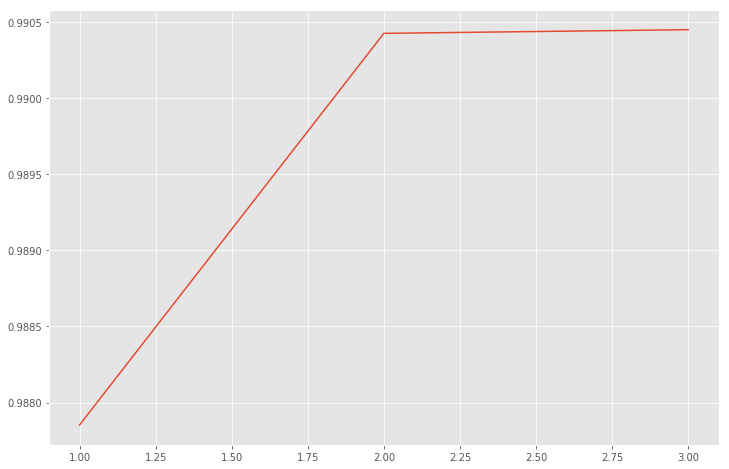

In [56]:
plt.plot(range(1, 4), clsfr_weights_test_scores.mean(axis=1))
    
print("weights: ", weights[np.where(clsfr_weights_test_scores.mean(axis=1) == clsfr_weights_test_scores.mean(axis=1).max())[0][0]])    
print(clsfr_weights_test_scores.mean(axis=1))

In [131]:
cross_val_score(clsfr, X, y, scoring='roc_auc', cv=cv)

C:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\stochas

array([ 0.99095497,  0.98914322,  0.99014815,  0.99129955,  0.99057631])

In [135]:
## веса фич подобрали, попробуем добавить стоп-слова
params = {
        'vect__description__tfidf__stop_words': [None, stopwords.words('russian')],
        'vect__name__tfidf__stop_words': [None, stopwords.words('russian')]
    }

In [136]:
clf_gs = GridSearchCV(clsfr, param_grid=params, scoring='roc_auc', cv=cv)

In [139]:
clf_gs.fit(X, y)

C:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\stochas

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', FeatureUnion(n_jobs=1,
       transformer_list=[('name', Pipeline(memory=None,
     steps=[('selector', ItemSelector(key='name')), ('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
 ...ty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'vect__description__tfidf__stop_words': [None, ['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'е...а', 'лучше', 'чуть', 'том', 'нельзя', 'такой', 'им', 'более', 'всегда', 'конечно', 'всю', '

In [140]:
print_test_results(clf_gs)

C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing

,0,2,3,1
mean_fit_time,5.72969,6.1127,6.02797,5.82736
mean_score_time,2.64569,2.77667,2.67706,2.61877
mean_test_score,0.990061,0.990051,0.989971,0.989943
mean_train_score,0.996169,0.996069,0.996056,0.996006
param_vect__description__tfidf__stop_words,None,"[и, в, во, не, что, он, на, я, с, со, как, а, то, все, она, так, его, но, да, ты, к, у, же, вы, за, бы, по, только, ее, мне, было, вот, от, меня, еще, нет, о, из, ему, теперь, когда, даже, ну, вдруг, ли, если, уже, или, ни, быть, был, него, до, вас, нибудь, опять, уж, вам, ведь, там, потом, себя, ничего, ей, может, они, тут, где, есть, надо, ней, для, мы, тебя, их, чем, была, сам, чтоб, без, будто, чего, раз, тоже, себе, под, будет, ж, тогда, кто, этот, того, потому, этого, какой, совсем, ним, здесь, этом, один, ...]","[и, в, во, не, что, он, на, я, с, со, как, а, то, все, она, так, его, но, да, ты, к, у, же, вы, за, бы, по, только, ее, мне, было, вот, от, меня, еще, нет, о, из, ему, теперь, когда, даже, ну, вдруг, ли, если, уже, или, ни, быть, был, него, до, вас, нибудь, опять, уж, вам, ведь, там, потом, себя, ничего, ей, может, они, тут, где, есть, надо, ней, для, мы, тебя, их, чем, была, сам, чтоб, без, будто, чего, раз, тоже, себе, под, будет, ж, тогда, кто, этот, того, потому, этого, какой, совсем, ним, здесь, этом, один, ...]",None
param_vect__name__tfidf__stop_words,None,None,"[и, в, во, не, что, он, на, я, с, со, как, а, то, все, она, так, его, но, да, ты, к, у, же, вы, за, бы, по, только, ее, мне, было, вот, от, меня, еще, нет, о, из, ему, теперь, когда, даже, ну, вдруг, ли, если, уже, или, ни, быть, был, него, до, вас, нибудь, опять, уж, вам, ведь, там, потом, себя, ничего, ей, может, они, тут, где, есть, надо, ней, для, мы, тебя, их, чем, была, сам, чтоб, без, будто, чего, раз, тоже, себе, под, будет, ж, тогда, кто, этот, того, потому, этого, какой, совсем, ним, здесь, этом, один, ...]","[и, в, во, не, что, он, на, я, с, со, как, а, то, все, она, так, его, но, да, ты, к, у, же, вы, за, бы, по, только, ее, мне, было, вот, от, меня, еще, нет, о, из, ему, теперь, когда, даже, ну, вдруг, ли, если, уже, или, ни, быть, был, него, до, вас, нибудь, опять, уж, вам, ведь, там, потом, себя, ничего, ей, может, они, тут, где, есть, надо, ней, для, мы, тебя, их, чем, была, сам, чтоб, без, будто, чего, раз, тоже, себе, под, будет, ж, тогда, кто, этот, того, потому, этого, какой, совсем, ним, здесь, этом, один, ...]"
params,"{'vect__description__tfidf__stop_words': None, 'vect__name__tfidf__stop_words': None}","{'vect__description__tfidf__stop_words': ['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', ...], 'vect__name__tfidf__stop_words': None}","{'vect__description__tfidf__stop_words': ['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'по

## Оценка классификаторов

In [154]:
## для работы на многих ядрах нужнен n_jobs = -1 кторый падает при использовании ItemSelectior
## поэтому, сначала выбираем и трансформируем фичи и только потом их обучаем на всех ядрах
matrix = vectorizer.fit_transform(X, y)

In [147]:
clf_select = Pipeline(
    [
        ('clf', SGDClassifier(random_state=random_state)),
    ]
)

In [175]:
params = [
    {
        'clf': [SGDClassifier(random_state=random_state)],
        'clf__alpha': [0.0001, 0.001, 0.01, 0.1, 1]
    },
    {
        'clf': [RandomForestClassifier(random_state=random_state)],
        'clf__n_estimators': [500, 1000, 1500]
    },
    {
        'clf': [LogisticRegression(random_state=random_state)],
        'clf__C': [0.01, 0.1, 1, 10]
    }
]

In [176]:
clf_select_cv = GridSearchCV(clf_select, param_grid=params, scoring='roc_auc', cv=3, n_jobs=-1)

In [159]:
train_matr = vectorizer.fit_transform(X_train)

In [177]:
clf_select_cv.fit(train_matr, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('clf', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'clf': [SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
   ...ver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)], 'clf__C': [0.01, 0.1, 1, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [178]:
print_test_results(clf_select_cv)

,9,7,6,10,5,8,1,11,0,2
mean_fit_time,241.566,12515.3,8845.64,569.175,4525.81,113.336,1.05767,1337.69,0.984674,1.52634
mean_score_time,0.0353336,68.1402,48.9413,0.0363336,25.823,0.0356691,0.0353347,0.0370003,0.0343278,0.0350005
mean_test_score,0.991818,0.990548,0.990523,0.990439,0.990435,0.9899,0.98847,0.986649,0.986584,0.985632
mean_train_score,0.997756,0.99999,0.99999,0.99974,0.999989,0.992562,0.993292,0.999983,0.995866,0.987284
param_clf,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,\n penalty='l2', random_state=42, solver='liblinear', tol=0.0001,\n verbose=0, warm_start=False)","RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_features='auto', max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,\n oob_score=False, random_state=42, verbose=0, warm_start=False)","RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_features='auto', max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,\n oob_score=False, random_state=42, verbose=0, warm_start=False)","LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,\n penalty='l2', random_state=42, solver='liblinear', tol=0.0001,\n verbose=0, warm_start=False)","RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_features='auto', max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,\n oob_score=False, random_state=42, verbose=0, warm_start=False)","LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,\n penalty='l2', random_state=42, solver='liblinear', tol=0.0001,\n verbose=0, warm_start=False)","SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,\n eta0=0.0, fit_intercept=True, l1_ratio=0.15,\n learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,\n n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,\n tol=None, verbose=0, warm_start=False)","LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,\n penalty='l2', random_state=42, solver='liblinear', tol=0.0001,\n verbose=0, warm_start=False)","SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,\n eta0=0.0, fit_intercept=True, l1_ratio=0.15,\n learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,\n n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,\n tol=None, verbose=0, warm_start=False)","SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,\n eta0=0.0, fit_intercept=True, l1_ratio=0.15,\n learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,\n n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,\n tol=None, verbose=0, warm_start=False)"
param_clf__C,0.1,NaN,NaN,1,NaN,0.01,NaN,10,NaN,NaN
param_clf__alpha,NaN,NaN,NaN,NaN,NaN,NaN,0.001,NaN,0.0001,0.01
param_clf__n_estimators,NaN,1500,1000,NaN,500,NaN,NaN,NaN,NaN,NaN
params,"{'clf': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2', random_state=42, solver='liblinear', tol=0.0001, verbose=0, warm_start=False), 'clf__C': 0.1}","{'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_d

In [179]:
test_matr = vectorizer.transform(X_test)

In [180]:
predictions = clf_select_cv.best_estimator_.predict(test_matr)

In [181]:
roc_auc_score(y_test, predictions)

0.96750357553187216

In [185]:
train_matr = vectorizer.fit_transform(train_data[['name', 'descriptionprocessed']])

In [187]:
clf_select_cv.best_estimator_.fit(train_matr, train_data['target'])

Pipeline(memory=None,
     steps=[('clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [195]:
test_texts = vectorizer.transform(test_data[['name', 'descriptionprocessed']])

In [196]:
predictions = clf_select_cv.best_estimator_.predict(test_texts)

In [198]:
set_answer(predictions, 'lr_predictions_C_0.1')

## Оценка SGD Classifier

In [ ]:
sgd_clf = Pipeline([
    ('vect', CountVectorizer(vocabulary=pos_vocabulary)),    
    ('clf', SGDClassifier(random_state=42, n_jobs=-1, alpha=0.001))
])

In [ ]:
alpha = [0.00001, 0.0001, 0.001, 0.01, 1, 10]
_, sgd_clf_alpha_test_scores = validation_curve(sgd_clf, X, y, 
                                                param_name='clf__alpha', param_range=alpha, 
                                                scoring='roc_auc', cv=cv, n_jobs=2)

plt.plot(np.log(alpha), sgd_clf_alpha_test_scores.mean(axis=1))
print("Alpha: ", alpha[np.where(sgd_clf_alpha_test_scores.mean(axis=1) == sgd_clf_alpha_test_scores.mean(axis=1).max())[0][0]])

In [ ]:
sgd_clf.fit(X, y)
test_predict = sgd_clf.predict(X_test)


print("ROC AUC Score: ", roc_auc_score(y_test, test_predict))

In [ ]:
parameters = [
    {  
        'vect': TfidfVectorizer(),
        'vect__min_df': (0.01, 0.1, 0.5)
        'vect__max_df': (1.0, 0.8, 0.5),
        'vect__ngram_range': [(1,1), (1,2), (1,3)],
        'tfidf__norm': ('l1', 'l2', None),
        'tfidf__use_idf': (True, False),
        'tfidf__smooth_idf': (True, False),
        'clf__loss': ('hinge', 'log'),    
        'clf__fit_intercept': (True, False)
    },
    {        
        'vect__min_df': (0.01, 0.1, 0.5)
        'vect__max_df': (1.0, 0.8, 0.5),
        'vect__ngram_range': [(1,1), (1,2), (1,3)],
        'clf__loss': ('hinge', 'log'),    
        'clf__fit_intercept': (True, False)
    }
]
    

In [ ]:
sgd_gs_clf = RandomizedSearchCV(sgd_clf, parameters, n_jobs=-1, cv=cv, scoring='roc_auc', random_state=123, n_iter=15)

In [ ]:
%%time

sgd_gs_clf.fit(X, y).best_score_

In [ ]:
print_test_results(sgd_gs_clf)

## Оценка Forest

In [ ]:
frst_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,2), vocabulary=pos_vocabulary)),
                     ('clf', RandomForestClassifier(random_state=123, n_jobs=-1,                                                 
                                                    n_estimators=1000,  
                                                    verbose=1,
                                                  ))
])

In [ ]:
frst_clf.fit(X_train, y_train)

In [ ]:
test_predict = frst_clf.predict(X_test)
print("ROC AUC Score: ", roc_auc_score(y_test, test_predict))

In [ ]:
frst_clf = Pipeline([('vect', CountVectorizer(min_df = 100, max_df=0.5, stop_words=['год', 'ооо'])),
                     ('tfidf', TfidfTransformer(smooth_idf=False)),
                     ('clf', RandomForestClassifier(random_state=123, n_jobs=-1, 
                                                    criterion='entropy', 
                                                    n_estimators=1300,  
                                                    verbose=1,
                                                    max_depth=25, min_samples_leaf=1,
                                                    min_samples_split=10,
                                                  ))
])

In [ ]:

cross_val_score(frst_clf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)

In [ ]:
estimators = np.linspace(100, 2000, 10, dtype=int)

_, forest_estimators_test_scores = validation_curve(frst_clf, X[:4000], y[:4000], param_name='clf__n_estimators', param_range=estimators, 
                 scoring='roc_auc', cv=cv, n_jobs=-1)

In [ ]:
plt.plot(estimators, forest_estimators_test_scores.mean(axis=1))

In [ ]:
depths = range(1, 50, 10)
_, forest_max_depth_test_scores = validation_curve(frst_clf, X[:4000], y[:4000], param_name='clf__max_depth', param_range=depths, 
                 scoring='roc_auc', cv=cv, n_jobs=-1)

In [ ]:
plt.plot(depths, forest_max_depth_test_scores.mean(axis=1))

In [ ]:
%%time

min_df = np.linspace(20, 500, 20, dtype=int)

_, forest_min_df_test_scores = validation_curve(frst_clf, X, y, param_name='vect__min_df', param_range=min_df, 
                 scoring='roc_auc', cv=cv, n_jobs=-1)

In [ ]:
plt.plot(min_df, forest_min_df_test_scores.mean(axis=1))
#print(min_df[np.where(forest_min_df_test_scores.max())], min_df, forest_min_df_test_scores.mean(axis=1).max())
print("Min_df: ", min_df[np.where(forest_min_df_test_scores.mean(axis=1) == forest_min_df_test_scores.mean(axis=1).max())])

In [ ]:
parameters = {    
    #'vect__max_df': (1.0, 0.8, 0.5),
    #'vect__min_df': (100, 500),
    'vect__ngram_range': [(1,1), (1,2), (1,3)],
    'tfidf__norm': (None, 'l2', 'l1'),
    'tfidf__use_idf': (True, False),
    'tfidf__smooth_idf': (True, False),    
    #'clf__n_estimators': np.linspace(900, 2500, 5, dtype=int),
    #'clf__criterion': ('entropy', 'gini'),
    #'clf__max_depth': np.linspace(10, 30, 5, dtype=int),
    #'clf__min_samples_split': (2, 10, 20),
    #'clf__min_samples_leaf': (1, 10, 50),   
}

In [ ]:
frst_gs_clf = RandomizedSearchCV(frst_clf, parameters, n_jobs=-1, cv=cv, scoring='roc_auc', random_state=123, n_iter=10)

In [ ]:
%%time

frst_gs_clf.fit(X, y).best_score_

In [ ]:
print_test_results(frst_gs_clf)

In [ ]:
frst_clf2 = Pipeline([('vect', CountVectorizer(min_df = 100, max_df=0.7)),                     
                     ('clf', RandomForestClassifier(random_state=123, n_jobs=-1, 
                                                    criterion='entropy', 
                                                    n_estimators=1300,                                                     
                                                    max_depth=25, min_samples_leaf=1,
                                                    min_samples_split=10,
                                                    ))
])

In [ ]:
frst_clf = None

In [ ]:
del(frst_clf)

In [ ]:
# stop_words=['год', 'ооо']
parameters = {    
    #'vect__max_df': (1.0, 0.8, 0.5),
    #'vect__min_df': (100, 500),
    #'vect__ngram_range': [(1,1), (1,2), (1,3)], 
    #'clf__n_estimators': np.linspace(900, 2500, 5, dtype=int),
    #'clf__criterion': ('entropy', 'gini'),
    #'clf__max_depth': np.linspace(10, 30, 5, dtype=int),ф
    #'clf__min_samples_split': (2, 10, 20),
    #'clf__min_samples_leaf': (1, 10, 50),   
}

In [ ]:
if __name__ == "__main__":   
    cross_val_score(frst_clf2, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)

In [ ]:
cv_score

In [ ]:
frst_gs_clf2 = GridSearchCV(frst_clf2, parameters, n_jobs=-1, cv=cv, scoring='roc_auc')

In [ ]:
%%time 

frst_gs_clf2.fit(X, y)

In [ ]:
print_test_results(frst_gs_clf2)

## Оценка логистической регрессии

In [ ]:
np.random.seed(15546)

rand_ind = np.hstack((np.random.choice(np.where(y==1)[0], 10000), np.random.choice(np.where(y==0)[0], 10000)))

In [ ]:
X = X_train[rand_ind]
y = y_train[rand_ind]

In [ ]:
text_clf = Pipeline([
    ('vect', CountVectorizer(max_df=0.5, min_df=100, ngram_range=(1,3), max_features=4000)),
    ('tfidf',  TfidfTransformer(norm=None, smooth_idf=True, use_idf=True)),
    ('clf', LogisticRegression(random_state=42, solver='saga', max_iter=500)),
])

In [ ]:
max_iter = range(300, 1000, 100)
_, lg_max_iter_test_scores = validation_curve(text_clf, X, y, param_name='clf__max_iter', param_range=max_iter, 
                 scoring='roc_auc', cv=cv, n_jobs=-1)

plt.plot(max_iter, lg_max_iter_test_scores.mean(axis=1))

In [ ]:
C = (0.001, 0.1, 1.0)
_, lg_C_test_scores = validation_curve(text_clf, X, y, param_name='clf__C', param_range=C, 
                 scoring='roc_auc', cv=cv, n_jobs=-1)

plt.plot(C, lg_C_test_scores.mean(axis=1))

In [ ]:
max_features = range(100, 10000, 500)
_, lg_max_features_test_scores = validation_curve(text_clf, X, y, param_name='vect__max_features', param_range=max_features, 
                 scoring='roc_auc', cv=cv, n_jobs=-1)

plt.plot(max_features, lg_max_features_test_scores.mean(axis=1))

In [ ]:
parameters = {
    #'vect__ngram_range': [(1, 2), (1, 3)],                            
    'vect__max_features': (2000, 3000, 4000),
    #'clf__max_iter': (300, 500, 700, 1000),
}

In [ ]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, scoring='roc_auc')

In [ ]:
%%time
gs_clf.fit(X, y).best_score_

In [ ]:
print_test_results(gs_clf)

In [ ]:
l = gs_clf.best_estimator_

In [ ]:
a = l.steps[2][1]

In [ ]:
matrix = l.steps[0][1]
matrix.

In [ ]:
len(matrix.get_feature_names())

In [ ]:
np.hstack([matrix.get_feature_names(), a.coef_[0, :]]).reshape((4000, 2), order='F')

In [ ]:
weigts = pd.DataFrame(np.hstack([matrix.get_feature_names(), a.coef_[0, :]]).reshape((4000, 2), order='F'),
             columns=['names', 'weigts'])

In [ ]:
weigts.sort_values('weigts', ascending=True)

In [ ]:
#gs_clf.transform()

## Обучение на всей выборке

In [ ]:
clf = Pipeline([('vect', CountVectorizer(min_df = 1000, max_df=0.5)),                     
                     ('clf', RandomForestClassifier(random_state=123, n_jobs=-1, 
                                                    criterion='entropy', 
                                                    n_estimators=1300,                                                     
                                                    max_depth=25, min_samples_leaf=1,
                                                    min_samples_split=10,
                                                    ))
])

In [ ]:
%%time 

clf.fit(X_train, y_train)

In [ ]:
test_predictions = clf.predict(X_test)

In [ ]:
roc_auc_score(y_test, test_predictions)

In [ ]:
predict_probabilities = lgr_clf.predict_proba(X_test)

In [ ]:
predict_probabilities[:, 1].shape

In [ ]:
y_test.shape

In [ ]:
fpr, tpr, _ = roc_curve(y_test, predict_probabilities[:, 0], pos_label=0)

In [ ]:
plt.plot(fpr, tpr)

In [ ]:
test_texts = getVacanciesLemmas(test_data.iloc[:, -1].values)

In [ ]:
result_predictions = frst_clf.predict(test_texts)

In [ ]:
set_answer(result_predictions, 'frst_predict33')